In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.sequence import pad_sequences
#from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model





In [104]:
print("GPUs disponibles:")
print(tf.config.list_physical_devices('GPU'))

GPUs disponibles:
[]


In [4]:
corpus=[]
target=[]
edad=[]
sexo=[]
severidad=[]
archivo=open("datasets/dataset_elpino.csv",encoding="utf-8") #pon aqui la ruta de tu dataset siendo el root donde se encuentra este codigo
header=archivo.readline().strip().split(";")
features=[]
for col in header:
    col=col.split("-")[0].strip()
    if col.startswith("Diag") or col.startswith("Proc"):
        col=col.split(" ")
        col=col[0]+col[1]
    features.append(col)
for linea in archivo:
    row=[]
    linea=linea.strip().split(";")
    for i in range(len(linea)):
        col=linea[i].split("-")[0].strip()
        if i==67:
            grd=col
            #target.append(grd[-1])
            target.append(grd)
        elif i==66:
            sexo.append(1 if col=="Mujer" else 0)
        elif i==65:
            edad.append(int(col))
        else:
            row.append(col)
    corpus.append(row)

archivo.close()

In [5]:
df=pd.DataFrame(corpus,columns=features[:-3])
df["GRD"]=target

In [6]:
#Junta todas las columnas de codigos en una sola lista
code_columns = [col for col in df.columns if col.startswith("Diag") or col.startswith("Proc")]

#Aplanar los codigos para construir el vocabulario
all_codes = df[code_columns].values.flatten()
unique_codes = pd.Series(all_codes).dropna().unique().tolist()

In [7]:
#Creacion del vocabulario
lookup_layer = tf.keras.layers.StringLookup(vocabulary=unique_codes, oov_token="[UNK]")

#Codigos a tensores de string y aplica StringLookup
X_codes_str = tf.constant(df[code_columns].astype(str).values)
X_codes_idx = lookup_layer(X_codes_str)

#Padding
X_padded = pad_sequences(X_codes_idx.numpy(), padding='post')

#Codifica los GRD como enteros
grd_lookup = tf.keras.layers.StringLookup(oov_token="[UNK]")
grd_lookup.adapt(df["GRD"])
y = grd_lookup(df["GRD"])

In [8]:
#Separar datos
X_train, X_test, y_train, y_test = train_test_split(X_padded, y.numpy(), test_size=0.3, random_state=42)


#Define modelo en Keras
vocab_size = lookup_layer.vocabulary_size()
num_classes = grd_lookup.vocabulary_size()

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=64),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),  # Dropout en capa densa
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#Entrenar modelo
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=120, batch_size=64)

#Evaluar modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy en test: {accuracy:.2%}")

In [ ]:
#Guarda el modelo
model.save("modelo_general_withDropout30epochs.keras")  #Cambiar nombres al momento de guardar
with open("historyMGdropout30E.pkl", "wb") as f:        #Cambiar nombres al momento de guardar
    pickle.dump(history.history, f)

In [299]:
#Carga el modelo
model = load_model("modelo_general.keras")

with open("historyMG.pkl", "rb") as f:    #Cambiar nombres al momento de guardar
    history = pickle.load(f)

d:\Users\Intel\Documents\Archivador\Proyectos\Universidad\Aprendizaje de Maquina\Embedding-ML\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [300]:
#Metricas de desempeño
y_pred = model.predict(X_test)
#Convierte predicciones a labels de clase discreta
y_pred_classes = np.argmax(y_pred, axis=1)  # Clase con mayor probabilidad

#Clasificacion
print(f"Reporte clasificacion:\n{classification_report(y_test, y_pred_classes)}")

137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Reporte clasificacion:
              precision    recall  f1-score   support

           1       0.95      0.97      0.96       231
           2       0.98      0.98      0.98       182
           3       0.98      0.96      0.97       162
           4       0.72      0.81      0.76       122
           5       0.85      0.88      0.86        98
           6       0.96      0.97      0.96        95
           7       0.92      0.91      0.91        87
           8       0.94      1.00      0.97        65
           9       0.88      0.99      0.93        72
          10       0.93      0.83      0.88        65
          11       0.89      0.96      0.93        79
          12       0.94      0.96      0.95        78
          13       0.87      0.90      0.88        59
          14       0.89      0.86      0.87        64
          15       0.88      0.96      0.92        54
          16       0.89      0.93      0.91        44
          17     

d:\Users\Intel\Documents\Archivador\Proyectos\Universidad\Aprendizaje de Maquina\Embedding-ML\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Users\Intel\Documents\Archivador\Proyectos\Universidad\Aprendizaje de Maquina\Embedding-ML\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Users\Intel\Documents\Archivador\Proyectos\Universidad\Aprendizaje de Maquina\Embedding-ML\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being 

In [ ]:
#Obtener predicciones y matriz
y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)

#Inicializar totales
TP_total = 0
FP_total = 0
FN_total = 0
TN_total = 0

#Total de clases
num_classes = cm.shape[0]
total_samples = np.sum(cm)

for i in range(num_classes):
    TP = cm[i, i]
    FP = np.sum(cm[:, i]) - TP
    FN = np.sum(cm[i, :]) - TP
    TN = total_samples - TP - FP - FN

    TP_total += TP
    FP_total += FP
    FN_total += FN
    TN_total += TN

print(f"Totales:")
print(f"TP: {TP_total}")
print(f"FP: {FP_total}")
print(f"FN: {FN_total}")
print(f"TN: {TN_total}")

137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Totales:
TP: 3037
FP: 1332
FN: 1332
TN: 2021515


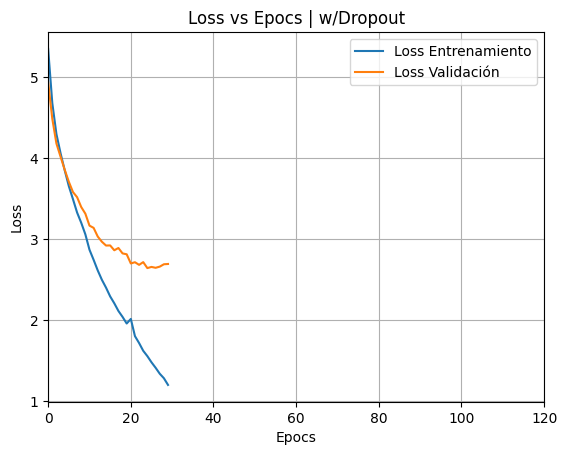

In [123]:
#Grafico epoch vs loss
plt.plot(history['loss'], label='Loss Entrenamiento')
plt.plot(history['val_loss'], label='Loss Validación')
plt.xlabel('Epocs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epocs | w/Dropout')
plt.grid(True)
plt.xlim(0, 120)
plt.show()

In [ ]:
#Predicciones
model = load_model("modelo_general.keras")

d:\Users\Intel\Documents\Archivador\Proyectos\Universidad\Aprendizaje de Maquina\Embedding-ML\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [271]:
def ver_entrada(i, X_test, y_test, df_original, lookup_layer, grd_lookup):
    # Invertir el lookup para obtener códigos originales
    inv_lookup_layer = tf.keras.layers.StringLookup(
        vocabulary=lookup_layer.get_vocabulary(),
        oov_token="[UNK]",
        invert=True
    )

    # Obtener entrada y expandir
    entrada = X_test[i]
    entrada_tensor = tf.constant(entrada)
    entrada_expandida = tf.expand_dims(entrada, axis=0)

    # Obtener predicción
    pred = model.predict(entrada_expandida, verbose=0)
    clase_predicha = tf.argmax(pred, axis=1).numpy()[0]

    # Decodificar GRDs
    grd_real = grd_lookup.get_vocabulary()[y_test[i]]
    grd_predicho = grd_lookup.get_vocabulary()[clase_predicha]

    # Decodificar códigos de la entrada
    codigos_originales = inv_lookup_layer(entrada_tensor).numpy()
    codigos_filtrados = [codigo.decode('utf-8') for codigo in codigos_originales if codigo.decode('utf-8') != '[UNK]']

    print("="*50)
    print(f"Entrada #{i}")
    print(f"GRD real:     {grd_real}")
    print(f"GRD predicho: {grd_predicho}")
    print("Códigos de diagnóstico/procedimiento:")
    for j, codigo in enumerate(codigos_filtrados):
        print(f"  {j + 1}. {codigo}")

In [281]:
ver_entrada(random.randint(0, 400), X_test, y_test, df, lookup_layer, grd_lookup)


Entrada #265
GRD real:     134161
GRD predicho: 134161
Códigos de diagnóstico/procedimiento:
  1. O10.0
  2. O21.9
  3. 
  4. 
  5. 
  6. 
  7. 
  8. 
  9. 
  10. 
  11. 
  12. 
  13. 
  14. 
  15. 
  16. 
  17. 
  18. 
  19. 
  20. 
  21. 
  22. 
  23. 
  24. 
  25. 
  26. 
  27. 
  28. 
  29. 
  30. 
  31. 
  32. 
  33. 
  34. 
  35. 
  36. 88.78
  37. 88.76
  38. 75.34
  39. 95.11
  40. 89.52
  41. 91.39
  42. 90.59
  43. 90.39
  44. 99.29
  45. 99.84
  46. 89.26
  47. 89.7
  48. 90.59
  49. 
  50. 
  51. 
  52. 
  53. 
  54. 
  55. 
  56. 
  57. 
  58. 
  59. 
  60. 
  61. 
  62. 
  63. 
  64. 
  65. 


<Axes: xlabel='GRD'>

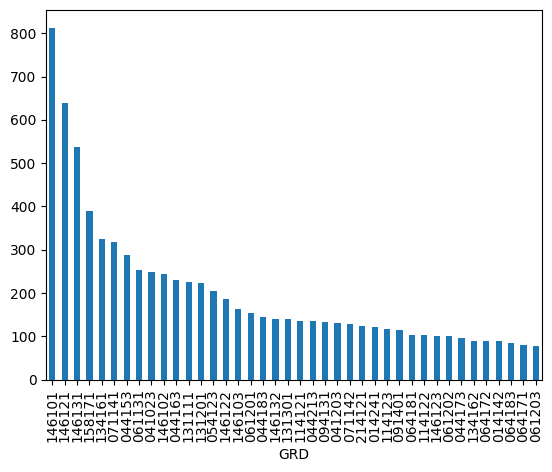

In [297]:
df["GRD"].value_counts()[:40].plot(kind="bar")

In [298]:
df["GRD"].value_counts()

GRD
146101    813
146121    639
146131    538
158171    389
134161    325
         ... 
214103      1
054223      1
114142      1
131122      1
134153      1
Name: count, Length: 526, dtype: int64